In [58]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import json
import cv2
import math

from main_monodepth_pytorch import Model
%reload_ext autoreload
%autoreload 2

Check if CUDA is available

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

2

In [4]:
torch.cuda.empty_cache()

## Test the model

In [5]:
images_names=os.listdir('data/test/image_2/image_02/data/')
images_names.sort()

In [7]:
for image in images_names:
    temp=cv2.imread('data/test/image_2/image_02/data/'+image, cv2.IMREAD_UNCHANGED)
    print(temp.shape[0:1])

(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(370,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(376,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)

(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(370,)
(370,)
(375,)
(370,)
(375,)
(374,)
(375,)
(376,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(374,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(374,)
(374,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(374,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(376,)
(375,)
(370,)
(375,)
(376,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(374,)
(370,)
(374,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)

(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(370,)
(370,)
(375,)
(375,)
(370,)
(375,)
(370,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(370,)
(376,)
(370,)
(375,)
(375,)
(375,)
(375,)

(375,)
(375,)
(375,)
(375,)
(370,)
(370,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(374,)
(370,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(370,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(374,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)

(375,)
(376,)
(375,)
(375,)
(375,)
(374,)
(370,)
(375,)
(374,)
(370,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(376,)
(376,)
(375,)
(374,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(370,)
(374,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)

(375,)
(370,)
(375,)
(375,)
(370,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(370,)
(376,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(370,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(376,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(376,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(374,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)
(370,)
(375,)
(375,)
(375,)
(375,)
(375,)

KeyboardInterrupt: 

In [66]:
labels_names=os.listdir('data/pif_all/')

In [67]:
labels_names.sort()

In [68]:
val_labels=open("val.txt", "r").read().split('\n')

In [71]:
maskbbox = []
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        with open('data/pif_all/'+label) as inputfile:
            temp = json.load(inputfile)

            if temp != []:
                for person in temp:
                    
                    new=[x/2 for x in person['bbox']]
                    keyp=[x/2 for x in person['keypoints']]
                   
                    confidence=sum(keyp[2::3])/(2*len(keyp[2::3]))
                    del keyp[2::3]

                    new.insert(0,i)
                    new.extend(keyp)
                    new.extend([confidence])

                    maskbbox.append(new)

    
         #   for line in inputfile:
         #       temp.append(line.strip().split(' '))
        #for line in temp:
        #    if line[0]=='Pedestrian':
        #        maskbbox.append([i, float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[-2])])
print(len(maskbbox))

4563


In [72]:
labels_names=os.listdir('data/training/label_2/')

In [73]:
labels_names.sort()

In [74]:
val_labels=open("val.txt", "r").read().split('\n')

In [75]:
gt = []
positions=[]
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        temp=[]
        with open('data/training/label_2/'+label) as inputfile:
            for line in inputfile:
                temp.append(line.strip().split(' '))
        for line in temp:
            if line[0]=='Pedestrian':
                gt.append([i, float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[-2])])
                positions.append([i,float(line[-4]),float(line[-3])])
print(len(gt))

2280


In [76]:
mask_val_bbox = []
for i in maskbbox:
    if int(i[0]) in list(map(int, val_labels)):
        mask_val_bbox.append(i)
        

In [77]:
maskbbox=np.array(mask_val_bbox)
print(len(maskbbox))

4563


In [78]:
def get_inter_area(r1, r2):
    left = max(r1[0], r2[0])
    right = min(r1[2], r2[2])
    bottom = max(r1[1], r2[1])
    top = min(r1[3], r2[3])
    return (top-bottom)*(right-left)


In [79]:
def get_union_area(r1, r2):
    return (r1[2]-r1[0])*(r1[3]-r1[1]) + (r2[2]-r2[0])*(r2[3]-r2[1]) - get_inter_area(r1, r2)

In [80]:
gt=np.array(gt)

In [81]:
all_images = list(set(gt[:,0].astype(int)))
final_boxes = []
for i in all_images:
    if len(gt[gt[:,0]==i])==0 or len(maskbbox[maskbbox[:,0]==i])==0:
        continue
    inter_matrix = np.zeros((len(gt[gt[:,0]==i]),len(maskbbox[maskbbox[:,0]==i])))
    for l, tbbox in enumerate(gt[gt[:,0]==i]):
        for k, mbbox in enumerate(maskbbox[maskbbox[:,0]==i]):
            inter_matrix[l,k]=get_inter_area(tbbox[1:5], mbbox[1:])/get_union_area(tbbox[1:5], mbbox[1:])
    for l in range(len(inter_matrix)):
        if inter_matrix[l][np.argmax(inter_matrix[l])]>0.3:
            final_boxes.append(np.append(maskbbox[maskbbox[:,0]==i][np.argmax(inter_matrix[l])],gt[gt[:,0]==i][l,-1])) 
            inter_matrix[:,np.argmax(inter_matrix[l])] = 0

In [25]:
dict_parameters_test = edict({'data_dir':'data/test',
                              'model_path':'data/models/monodepth_resnet18_001.pth',
                              'output_directory':'data/output/',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':True,
                              'mode':'test',
                              'device':'cuda:0',
                              'input_channels':3,
                              'num_workers':4,
                              'use_multiple_gpu':False})
model_test = Model(dict_parameters_test)

Use a dataset with 7481 images


In [18]:
model_test.test()

Finished Testing


In [82]:
disp = np.load('data/output/disparities_pp.npy')  # Or disparities.npy for output without post-processing
disp.shape

(7481, 256, 512)

In [83]:
np.array(final_boxes).shape

(1892, 41)

In [84]:
errors=[]
for box in final_boxes:
    disp_to_img = skimage.transform.resize(disp[int(box[0])].squeeze(), [375, 1242], mode='constant')
    depth = 0.54 * 721 / (1242 * disp_to_img)
    pred = []
    
    for joint in list(zip(box[5:-2][::2],box[5:-2][1::2])):
        
        if (((joint[1]+3)<depth.shape[0]) & ((joint[0]+3)<depth.shape[1])):
            for i in range(3):
                for j in range(3):
                    pred.append(depth[int(joint[1])+i,int(joint[0])+j])
                    pred.append(depth[int(joint[1])-i,int(joint[0])+j])
                    pred.append(depth[int(joint[1])+i,int(joint[0])-j])
                    pred.append(depth[int(joint[1])-i,int(joint[0])-j])
    
    pred=min(pred)
    #pred=sum(pred)/len(pred)
    
        
    gtruth=box[-1]

    errors.append([gtruth,pred,pred-gtruth,int(box[0])])


for i, errors in enumerate(all_errors):
    errors=np.array(errors)
    print(i+2,'average error in m: ', abs(errors[:,2]).mean())

In [85]:
errors=np.array(errors)
print('average error in m: ', abs(errors[:,2]).mean())

average error in m:  2.83473987891


errors = np.array(all_errors[47])

clean_errors = errors[abs(errors[:,2])<20]

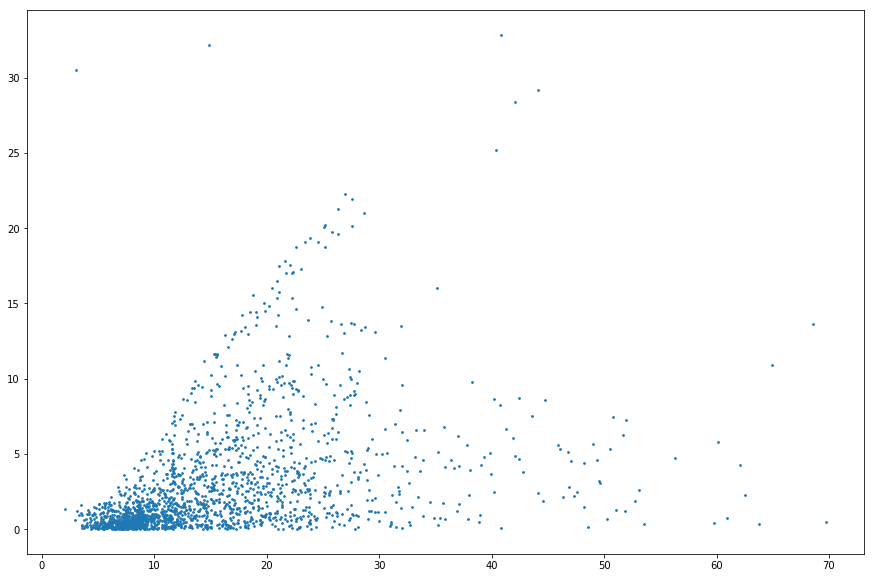

In [87]:
plt.scatter(errors[:,0],abs(errors[:,2]),s=3)
plt.show()

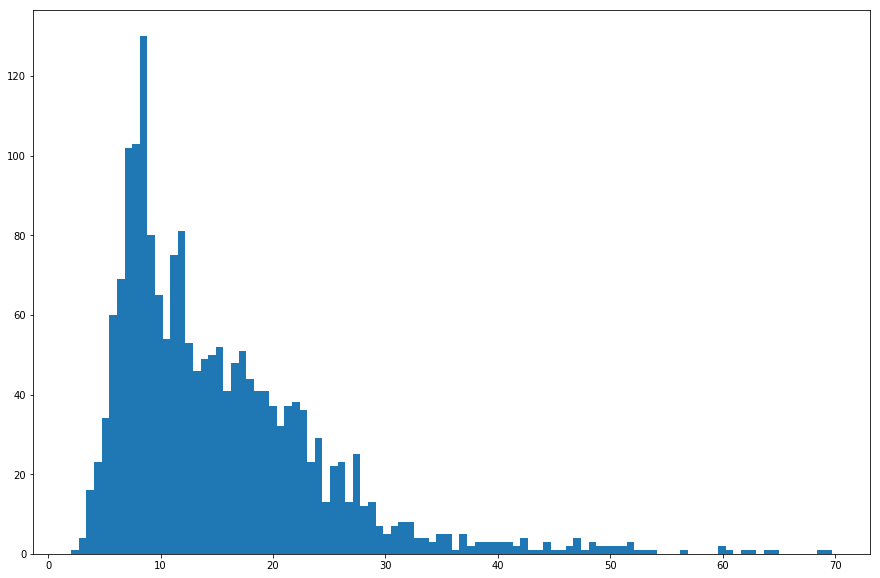

In [88]:
plt.hist(errors[:,0], bins=100)
plt.show()

In [89]:
print('average error in m: ', abs(errors[:,2]).mean())
print('median error in m: ', np.median(abs(errors[:,2])),'\n')

print('smaller than 0.5m: ', len(errors[abs(errors[:,2])<0.5])/len(gt)*100,'%')
print('smaller than 1m: ', len(errors[abs(errors[:,2])<1])/len(gt)*100,'%')
print('smaller than 2m: ', len(errors[abs(errors[:,2])<2])/len(gt)*100,'%\n')

print('the recall is: ', len(errors)*100/len(gt),'%')
print('the rate of false positives is: ',(len(maskbbox)-len(errors))*100/len(maskbbox),'%')

average error in m:  2.83473987891
median error in m:  1.3499138567 

smaller than 0.5m:  19.517543859649123 %
smaller than 1m:  34.82456140350877 %
smaller than 2m:  50.13157894736842 %

the recall is:  82.98245614035088 %
the rate of false positives is:  58.536050843743155 %


In [90]:
temp_errors=errors[errors[:,0]<5]
print('average error for gt < 5m :        ', abs(temp_errors[:,2]).mean(),'  median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<10]
temp_errors=temp_errors[temp_errors[:,0]>5]
print('average error for 5m < gt < 10m :  ', abs(temp_errors[:,2]).mean(),' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<15]
temp_errors=temp_errors[temp_errors[:,0]>10]
print('average error for 10m < gt < 15m : ', abs(temp_errors[:,2]).mean(),' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<20]
temp_errors=temp_errors[temp_errors[:,0]>15]
print('average error for 15m < gt < 20m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<25]
temp_errors=temp_errors[temp_errors[:,0]>20]
print('average error for 20m < gt < 25m : ', abs(temp_errors[:,2]).mean(), '  median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<30]
temp_errors=temp_errors[temp_errors[:,0]>25]
print('average error for 25m < gt < 30m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]>30]
print('average error for gt > 30m :       ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))



average error for gt < 5m :         1.15554936576   median error:  0.475146198656
average error for 5m < gt < 10m :   0.840718781815  median error:  0.612666601805
average error for 10m < gt < 15m :  2.3193098895  median error:  1.58532200469
average error for 15m < gt < 20m :  3.97973027157  median error:  2.87809074426
average error for 20m < gt < 25m :  5.14984965659   median error:  3.51712950988
average error for 25m < gt < 30m :  6.24184595186  median error:  4.63084522182
average error for gt > 30m :        4.85143105971  median error:  3.9765812954


In [91]:
temp_errors=errors[errors[:,0]<20]
print('average error for gt < 20m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
print('smaller than 0.5m: ', len(temp_errors[abs(temp_errors[:,2])<0.5])/len(temp_errors)*100,'%')
print('smaller than 1m: ', len(temp_errors[abs(temp_errors[:,2])<1])/len(temp_errors)*100,'%')
print('smaller than 2m: ', len(temp_errors[abs(temp_errors[:,2])<2])/len(temp_errors)*100,'%')

average error for gt < 20m :  2.02438232222  median error:  1.02314599078
smaller than 0.5m:  28.401953942777393 %
smaller than 1m:  49.546406140963015 %
smaller than 2m:  70.13258897418004 %


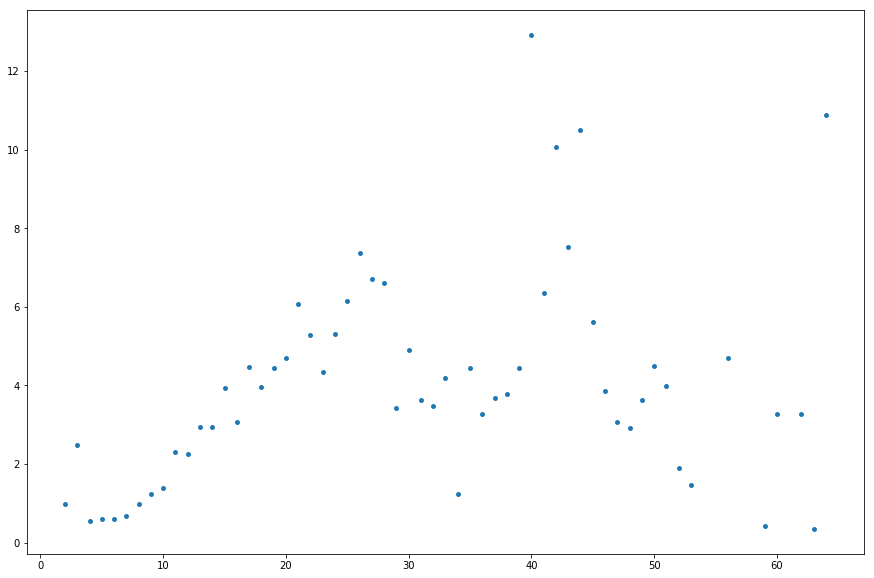

In [92]:
mean_errors=[]
x_errors=[]
for i in range(int(min(errors[:,0])), int(max(errors[:,0]))-3):
    temp_errors=errors[errors[:,0]<i+1]
    temp_errors=temp_errors[temp_errors[:,0]>i]
    if temp_errors.any()!=0:
        mean_errors.append(abs(temp_errors[:,2]).mean())
        x_errors.append(i)
plt.scatter(x_errors,mean_errors,s=15)
plt.show()

In [93]:
np.corrcoef(x=x_errors,y=mean_errors)

array([[ 1.        ,  0.30968335],
       [ 0.30968335,  1.        ]])

In [94]:
all_boxes=np.array(final_boxes)

In [95]:
positions=np.array(positions)

In [96]:
#print(all_boxes[all_boxes[:,0]==4098])
#print(errors[errors[:,-1]==4098])
#print(positions[positions[:,0]==4098])
#print(all_boxes[all_boxes[:,0]==4098][:,1:5],all_boxes[all_boxes[:,0]==4098][:,-2],)
for i, box in enumerate(all_boxes[all_boxes[:,0]==4098]):
    distance=0
    for item in box[1:5]:
        print(item,',')
    print(box[-2],',')
    for item in positions[positions[:,0]==4098][i][1:]:
        distance+=item**2
    distance+=errors[errors[:,-1]==4098][i][1]**2
    print(math.sqrt(distance))

735.776809156 ,
162.661987305 ,
750.193047285 ,
185.563382149 ,
0.310294117647 ,
15.140296435106245
755.414212704 ,
160.706382692 ,
767.434480488 ,
188.401648521 ,
0.251470588235 ,
15.00648557652844


In [62]:
print(int(val_labels[0]))

1


In [36]:
print(errors[3])

[ 23.02        20.57458052  -2.44541948   5.        ]


In [66]:
errors[2]

array([   27.48      ,    13.79624983,   -13.68375017,  4098.        ])

In [101]:
for label in val_labels:
    f= open("data/final-pifpaf/"+label+".txt","w+")
    for i, box in enumerate(all_boxes[all_boxes[:,0]==int(label)]):
        distance=0
        for item in box[1:5]:
            f.write(str(item))
            f.write(', ')
        f.write(str(box[-2]))
        f.write(', ')

        for item in positions[positions[:,0]==int(label)][i][1:]:
            distance+=item**2
        distance+=errors[errors[:,-1]==int(label)][i][1]**2
        f.write(str(math.sqrt(distance)))
        f.write('\n')
    f.close()

#### example of an image

In [30]:
fig,ax = plt.subplots(1)

In [1]:
image_id=1880

In [2]:
disp_to_img = skimage.transform.resize(disp[image_id].squeeze(), [375, 1242], mode='constant')
ax.imshow(disp_to_img, cmap='plasma')

NameError: name 'skimage' is not defined

In [50]:
disp_bbox = np.array(final_boxes)[np.array(final_boxes)[:,0]==image_id]

In [55]:
disp_bbox=list(disp_bbox[0])

In [35]:
ax.add_patch(
            plt.Rectangle((disp_bbox[0+1], disp_bbox[1+1]),
                          disp_bbox[2+1] - disp_bbox[0+1],
                          disp_bbox[3+1] - disp_bbox[1+1],
                          fill=False, edgecolor='white',
                          linewidth=0.5, alpha=1))

In [48]:
depth = 0.54 * 721 / (1242 * disp_to_img)

In [49]:
#depth[int(disp_bbox[1+1]):int(disp_bbox[3+1]),int(disp_bbox[0+1]):int(disp_bbox[2+1])].min()
errors[errors[:,-1]==image_id]

array([[  5.25000000e+00,   6.29862428e+00,   1.04862428e+00,
          4.22300000e+03]])

In [60]:
len(disp_bbox[5:-1])
for joint in list(zip(disp_bbox[5:-1][::2],disp_bbox[5:-1][1::2])):
    if ((joint[1]<depth.shape[0]) & (joint[0]<depth.shape[1])):
        ax.add_patch(
            plt.Rectangle(joint,
                          3,
                          3,
                          fill=True, edgecolor='white',
                          linewidth=0.5, alpha=1))
        #print(joint)
        #pred.append(depth[int(joint[1]),int(joint[0])])
    

In [61]:
disp_bbox[-1]

5.25

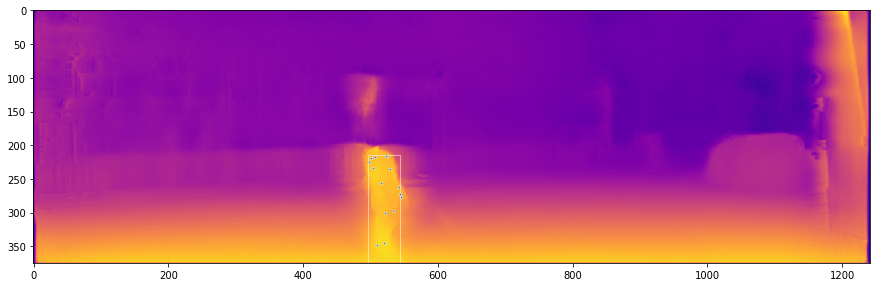

In [62]:
plt.show()

In [55]:
from IPython.display import Image

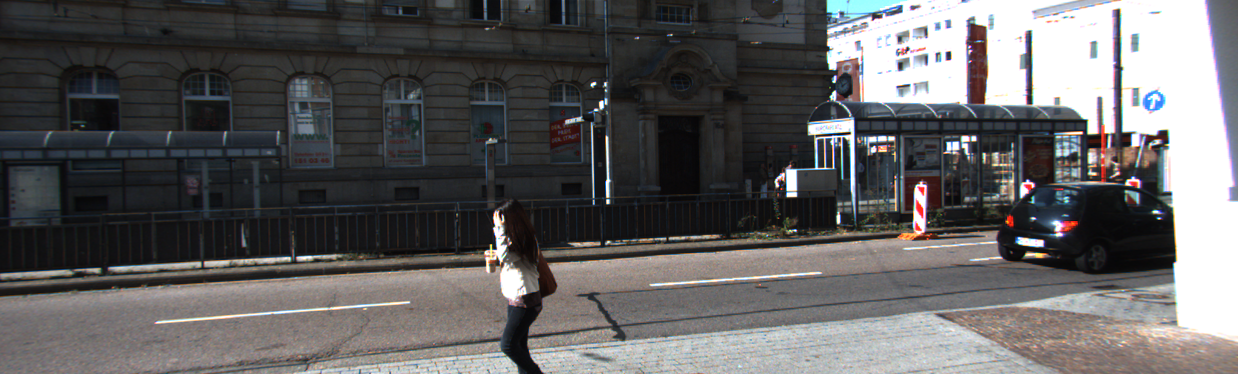

In [57]:
Image(filename = 'data/test/image_2/image_02/data/004223.png')